In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

In [2]:
#dataset = pd.read_csv('../dataset-processed/pre-processed-01.csv')
dataset = pd.read_csv('../dataset-processed/pre-processed-02-brand-paid.csv')
print("Numero di esempi: ", len(dataset))
dataset.head()

Numero di esempi:  11905


,hashtag,tag,caption,is_video,n_comment,n_likes,target,timestamp_1,timestamp_2,timestamp_3,timestamp_4,timestamp_5,timestamp_6
0,0,0,52,0,0.000116,0.042888,1,0,0,0,1,0,0
1,0,0,44,0,0.000174,0.057932,1,0,1,0,0,0,0
2,2,4,16,1,0.000044,0.019899,1,0,0,1,0,0,0
3,0,0,1,1,0.000256,0.042174,1,0,1,0,0,0,0
4,0,1,26,0,0.000099,0.042953,1,1,0,0,0,0,0


### Feature selection

In [3]:
from sklearn.feature_selection import SelectKBest, chi2

In [4]:
X = dataset.drop(labels=['target'], axis = 1)
y = dataset['target']

In [5]:
X.shape

(11905, 12)

In [6]:
X = SelectKBest(chi2, k=7).fit_transform(X, y)

In [7]:
X.shape

(11905, 7)

In [8]:
dataset['target'].value_counts()

1    11420
0      485
Name: target, dtype: int64

### Z-score

In [9]:
# z-score
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [11]:
print('Esempi training standard: ', sum(y_train == 1))
print('Esempi training paid: ', sum(y_train == 0))

Esempi training standard:  9136
Esempi training paid:  388


In [12]:
print('Esempi training standard: ', sum(y_test == 1))
print('Esempi training paid: ', sum(y_test == 0))

Esempi training standard:  2284
Esempi training paid:  97


### Inflate

In [13]:
from imblearn.over_sampling import SMOTE

In [14]:
sm = SMOTE(random_state=2)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())
X_train.shape, y_train.shape

((18272, 7), (18272,))

In [15]:
print('Esempi training standard: ', sum(y_train == 1))
print('Esempi training paid: ', sum(y_train == 0))

Esempi training standard:  9136
Esempi training paid:  9136


In [16]:
sm = SMOTE(random_state=2)
X_test, y_test = sm.fit_sample(X_test, y_test.ravel())
X_test.shape, y_test.shape

((4568, 7), (4568,))

In [17]:
print('Esempi test standard: ', sum(y_test == 1))
print('Esempi test paid: ', sum(y_test == 0))

Esempi test standard:  2284
Esempi test paid:  2284


### Neural network model

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
print(tf.__version__)

2.0.0


In [19]:
def create_model():
    model = Sequential()
    model.add(Dense(X.shape[1], activation="relu", input_dim = X.shape[1]))
    model.add(Dense(512, activation="relu"))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics=['accuracy'])
    
    return model

In [20]:
model_nn = create_model()
model_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 7)                 56        
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4096      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 168,505
Trainable params: 168,505
Non-trainable params: 0
_________________________________________________________________


In [21]:
epochs = 5
history = model_nn.fit(X_train, y_train, batch_size = 10, epochs = epochs, verbose = 1, validation_data=(X_test, y_test))



Train on 18272 samples, validate on 4568 samples
Epoch 1/5
18272/18272 [==============================] - 13s 692us/sample - loss: 0.4511 - accuracy: 0.7867 - val_loss: 0.4619 - val_accuracy: 0.8240
Epoch 2/5
18272/18272 [==============================] - 12s 653us/sample - loss: 0.3894 - accuracy: 0.8194 - val_loss: 0.5367 - val_accuracy: 0.8312
Epoch 3/5
18272/18272 [==============================] - 12s 659us/sample - loss: 0.3616 - accuracy: 0.8413 - val_loss: 0.5847 - val_accuracy: 0.8314
Epoch 4/5
18272/18272 [==============================] - 12s 662us/sample - loss: 0.3481 - accuracy: 0.8489 - val_loss: 0.5291 - val_accuracy: 0.8266
Epoch 5/5
18272/18272 [==============================] - 12s 668us/sample - loss: 0.3384 - accuracy: 0.8552 - val_loss: 0.5589 - val_accuracy: 0.8317


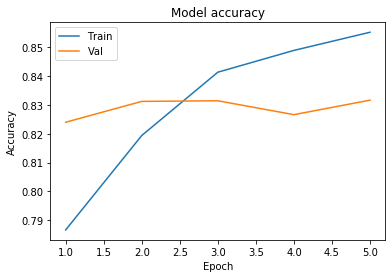

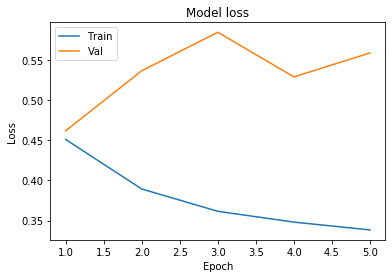

In [22]:
# Plot training & validation accuracy values
epoch_range = range(1, epochs+1)
plt.plot(epoch_range, history.history['accuracy'])
plt.plot(epoch_range, history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

### Evaluate the model

In [30]:
y_pred = model_nn.predict_classes(X_test)
accuracy_score(y_test, y_pred)

0.8316549912434326

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a618a2c50>)

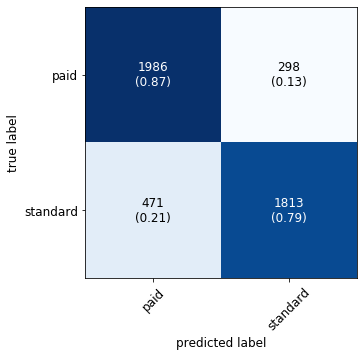

In [31]:
class_names = ['paid', 'standard']
font = {'size': 12}
matplotlib.rc('font', **font)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, figsize=(5,5), class_names = class_names, show_normed=True)

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      2284
           1       0.86      0.79      0.83      2284

    accuracy                           0.83      4568
   macro avg       0.83      0.83      0.83      4568
weighted avg       0.83      0.83      0.83      4568



In [33]:
y_pred = model_nn.predict_proba(X_test)

(1187,)
4356
[0.         0.02758319 0.03064799 0.03502627 0.03721541 0.03896673
 0.03940455 0.04115587 0.0415937  0.04334501 0.04422067 0.04684764
 0.04728546 0.04816112 0.04816112 0.05035026 0.05341506 0.05429072
 0.05429072 0.05472855 0.05516637 0.0556042  0.05691769 0.05823117
 0.058669   0.06085814 0.06129597 0.06217163 0.06217163 0.06304729
 0.06392294 0.0647986  0.06567426 0.06654991 0.06742557 0.0678634
 0.06873905 0.06917688 0.06961471 0.07049037 0.07267951 0.07267951
 0.07311734 0.07311734 0.07443082 0.07530648 0.07574431 0.07574431
 0.07661996 0.07837128]
[2.         1.         0.99999994 0.9999999  0.9999998  0.99999976
 0.9999997  0.99999964 0.9999996  0.9999995  0.99999946 0.9999994
 0.99999934 0.9999993  0.9999992  0.99999917 0.99999905 0.999999
 0.9999989  0.99999887 0.9999988  0.99999875 0.9999987  0.99999857
 0.9999985  0.99999845 0.9999983  0.9999982  0.99999815 0.999998
 0.9999979  0.99999785 0.99999774 0.9999977  0.9999976  0.99999756
 0.9999975  0.9999974  0.999997

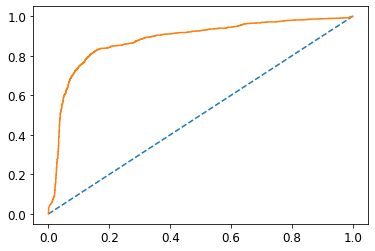

0.8796701373446897


In [34]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_pred = model_nn.predict_proba(X_test)
# keep probabilities for the positive outcome only
#y_pred = y_pred[:, 1]
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print(fpr.shape)
print(len(np.unique(y_pred)))
print(tpr[:50])
print(thresholds[:50])
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr)
# show the plot
plt.show()


# calculate roc auc
auc = roc_auc_score(y_test, y_pred)
print(auc)

In [35]:
def find_optimal_cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    #i = np.arange(len(tpr)) 
    #roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    #roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    idx = np.argmax(tpr - fpr)
    print(tpr[idx], fpr[idx])
    return threshold[idx]
    #return list(roc_t['threshold']) 

y_pred = model_nn.predict_proba(X_test)

threshold = find_optimal_cutoff(y_test, y_pred)
print(threshold)

y_pred_new = [1 if x > threshold else 0 for x in y_pred]
accuracy_score(y_test, y_pred_new)

0.824430823117338 0.15280210157618213
0.4006873


0.8355954465849387

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a61db1710>)

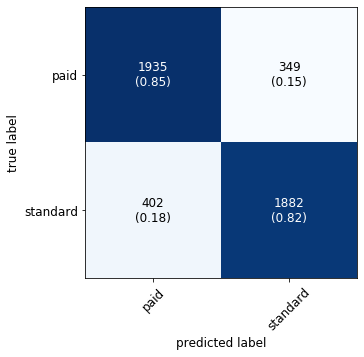

In [36]:
class_names = ['paid', 'standard']
font = {'size': 12}
matplotlib.rc('font', **font)
mat = confusion_matrix(y_test, y_pred_new)
plot_confusion_matrix(conf_mat=mat, figsize=(5,5), class_names = class_names, show_normed=True)

In [37]:
print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      2284
           1       0.84      0.82      0.83      2284

    accuracy                           0.84      4568
   macro avg       0.84      0.84      0.84      4568
weighted avg       0.84      0.84      0.84      4568



### Logistic Regression Model

In [38]:
from sklearn.linear_model import LogisticRegression

In [39]:
classifier_lr = LogisticRegression(class_weight={0: 1, 1: 1})
classifier_lr.fit(X_train, y_train)
y_pred = classifier_lr.predict(X_test)

accuracy = classifier_lr.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.7206654991243433


(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a618464e0>)

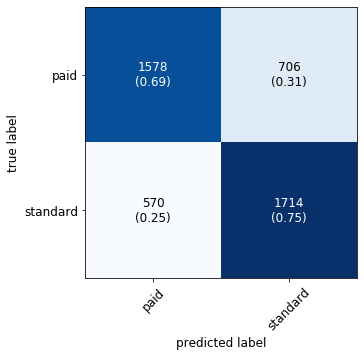

In [40]:
class_names = ['paid', 'standard']
font = {'size': 12}
matplotlib.rc('font', **font)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, figsize=(5,5), class_names = class_names, show_normed=True)

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.69      0.71      2284
           1       0.71      0.75      0.73      2284

    accuracy                           0.72      4568
   macro avg       0.72      0.72      0.72      4568
weighted avg       0.72      0.72      0.72      4568



### SVM Model

In [42]:
from sklearn.svm import SVC

In [43]:
classifier_svm = SVC(class_weight={0: 1, 1: 1})
classifier_svm.fit(X_train, y_train)
y_pred = classifier_svm.predict(X_test)

accuracy = classifier_svm.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8445709281961471


(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a61e078d0>)

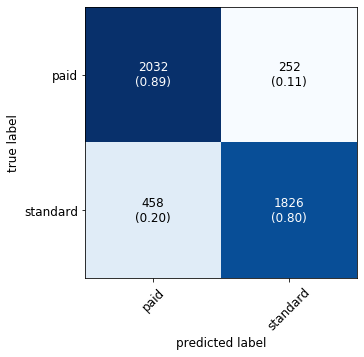

In [44]:
class_names = ['paid', 'standard']
font = {'size': 12}
matplotlib.rc('font', **font)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, figsize=(5,5), class_names = class_names, show_normed=True)

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85      2284
           1       0.88      0.80      0.84      2284

    accuracy                           0.84      4568
   macro avg       0.85      0.84      0.84      4568
weighted avg       0.85      0.84      0.84      4568



### Random Forest Model

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
# max_features=3
classifier_rf = RandomForestClassifier(max_depth=2, max_leaf_nodes=3)
classifier_rf.fit(X_train, y_train)
y_pred = classifier_rf.predict(X_test)

accuracy = classifier_rf.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8517950963222417


(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a61fcd828>)

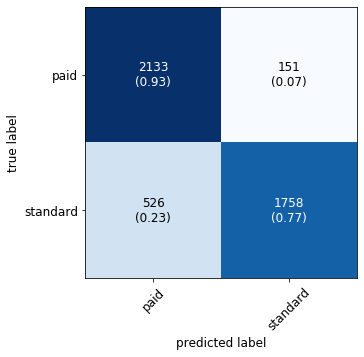

In [48]:
class_names = ['paid', 'standard']
font = {'size': 12}
matplotlib.rc('font', **font)
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, figsize=(5,5), class_names = class_names, show_normed=True)

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86      2284
           1       0.92      0.77      0.84      2284

    accuracy                           0.85      4568
   macro avg       0.86      0.85      0.85      4568
weighted avg       0.86      0.85      0.85      4568



### T-test

In [50]:
from sklearn.model_selection import cross_val_score
from scipy import stats
X, y = sm.fit_sample(X, y)

scores = []

In [51]:
scores_lr = cross_val_score(classifier_lr, X, y, cv=10) # score=accuracy
scores.append(scores_lr)

In [52]:
scores_svm = cross_val_score(classifier_svm, X, y, cv=10) # score=accuracy
scores.append(scores_svm)

In [53]:
scores_rf = cross_val_score(classifier_rf, X, y, cv=10) # score=accuracy
scores.append(scores_rf)

In [62]:
scores[2].mean()

0.826401050788091

In [55]:
t, p = stats.ttest_rel(scores_lr, scores_svm)
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -29.147
p value: 0.000


In [56]:
t, p = stats.ttest_rel(scores_svm, scores_rf)
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 6.793
p value: 0.000


In [58]:
t, p = stats.ttest_rel(scores_lr, scores_rf)
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: -42.978
p value: 0.000


Dato che `abs(t) > critival_calue` rifiutiamo l'ipotesi nulla (i due modelli sono significativamente differenti)

Dato che `p <= alpha` rifiutiamo l'ipotesi nulla (i due modelli sono significativamente differenti)